In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

%matplotlib inline

## Load in training data set

In [2]:
df_orig = pd.read_csv('../data/train.csv')

In [3]:
df_orig.shape

(1460, 81)

In [4]:
df_orig.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Deal with missingness

### Currently just imputing 0 for everything missing

In [5]:
df_imputed = df_orig.fillna(0)

## Replace categorical variables with dummies

### At this stage just dummying everything, but note that we may want to do linear ("ordinal"?) dummifying for variables like ExterQual which has a clear order to the categories

In [6]:
# grab the categorical variables
df_categorical = df_imputed.select_dtypes(include=['object'])
# print out the names
df_categorical.columns;
# make a copy for modifications
df = df_imputed.copy()

In [25]:
df_categorical.columns;
set(df_orig.Condition2); #probably just dummy this
set(df_orig.ExterQual); #could maybe make this ordinal/e.g. 0-4 valued
set(df_orig.PavedDrive) #is this Yes No and... probably??
df_orig.PavedDrive.value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [8]:
# runs through categorical columns and does 2 things
# 1) dummy out (and remove redundant dummy)
# 2) remove original categorical variable
for i in df_categorical.columns:
    df = df.join(pd.get_dummies(df[i], prefix = i, prefix_sep = '_', drop_first=True))
    df = df.drop(i, 1)

In [9]:
# many more variables now but NONE are categorical
print(df_orig.shape);
print(df_categorical.shape);
print(df.shape);

(1460, 81)
(1460, 43)
(1460, 263)


## Train a linear model

In [10]:
# create X and y
# X drops Sale price and Id
X = df.loc[:, df.columns != 'SalePrice']
X = X.loc[:, X.columns != 'Id']
y = df['SalePrice']

In [11]:
# split train and test set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# train the model
from sklearn import linear_model
ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
print("R^2 for train set: %f" %ols.score(X_train, y_train))
print('-'*50)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))

R^2 for train set: 0.940730
--------------------------------------------------
R^2 for test  set: -1.783994


### This is a surprisingly bad R^2 score for the test set... Josh then goes on to eliminate variables that may be confusing things

## Eliminating some variables

In [14]:
X_train.shape

(1022, 261)

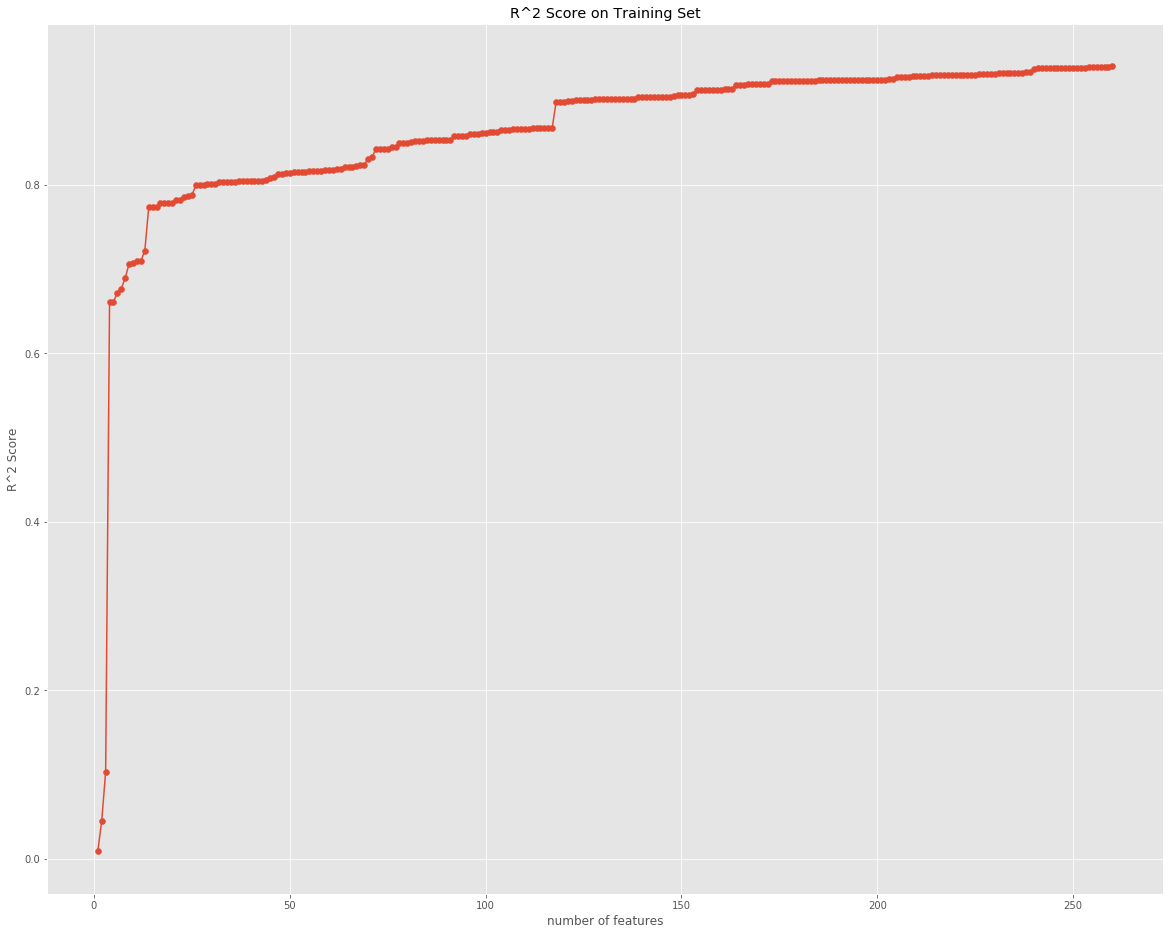

In [15]:
n = range(1, X_train.shape[1])
r2_vec_train = []
for i in n:
    ols.fit(X_train.iloc[:, 0:i] , y_train)
    r2_vec_train.append(ols.score(X_train.iloc[:, 0:i] , y_train))
plt.figure(figsize=(20,16))
plt.scatter(n, r2_vec_train)
plt.plot(n, r2_vec_train)
plt.xlabel('number of features')
plt.ylabel('R^2 Score')
plt.title('R^2 Score on Training Set')
plt.show()

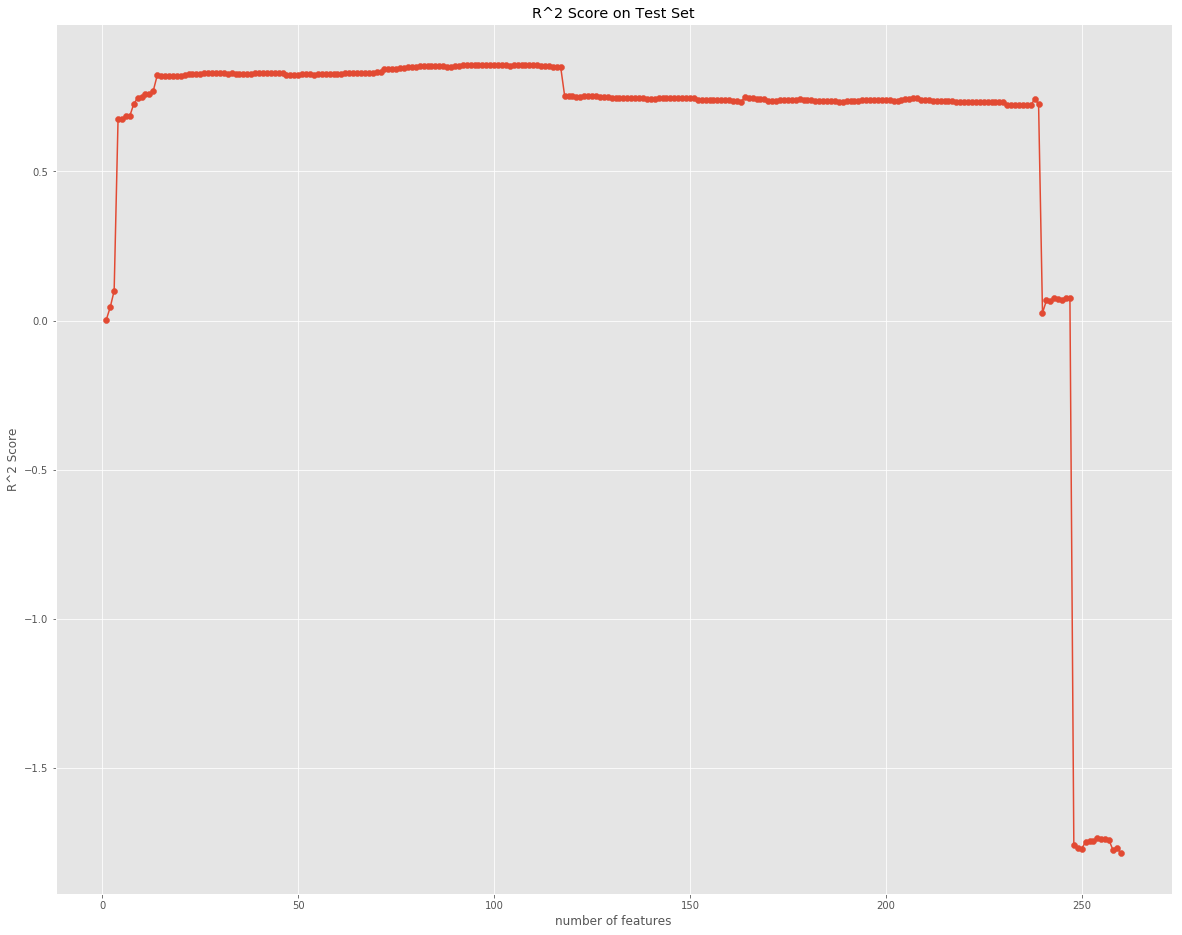

In [16]:
r2_vec_test = []
for i in n:
    ols.fit(X_train.iloc[:, 0:i] , y_train)
    r2_vec_test.append(ols.score(X_test.iloc[:, 0:i] , y_test))
plt.figure(figsize=(20,16))
plt.scatter(n, r2_vec_test)
plt.plot(n, r2_vec_test)
plt.xlabel('number of features')
plt.ylabel('R^2 Score')
plt.title('R^2 Score on Test Set')
plt.show()

In [17]:
r2_max_test = max(r2_vec_test)
max_index = [i for i, j in enumerate(r2_vec_test) if j == r2_max_test]

In [18]:
print('The highest R^2 score is: %0.4f with 1 to %i features' % (r2_max_test, max_index[0]+1))

The highest R^2 score is: 0.8580 with 1 to 98 features


In [21]:
ols.fit(X_train.iloc[:, 0:max_index[0]+1] , y_train)
ols.score(X_test.iloc[:, 0:max_index[0]+1], y_test)

0.8580462767723587